In [1]:
# Initial setup
import pandas as pd
import numpy as np
df = pd.read_excel('1EuropeTop100Attractions_ENG_20190101_20210821_8d41002054da83b2174ac7d4b22d2828.xlsx')

#DATA UNDERSTANDING
#df.describe()

#we discovered a user had over 60,000 contributions,this is an error or an outlier

In [2]:
#DATA PREPARATION
#DATA CLEANING
#fill all empty user location with unknownL and empty triptype with unknownT
df["userLocation"].fillna('unknownL', inplace=True)
df['tripType'].fillna('unknownT', inplace=True)

#remove rows having empty review visited colomn
df.dropna(subset=["reviewVisited"], inplace=True)

#It appears that some rows are the same but for the extraction date column
#hence we drop the extraction date column before we remove duplicates

#remove extraction date
df_no_extr_date =df.drop("extractionDate", axis=1)

#remove duplicates
df_no_duplicates = df_no_extr_date.drop_duplicates()

#Remove the review text colomn
df_no_duplicates = df_no_duplicates.drop("reviewFullText",axis=1)

#Remove the review language column
df_no_duplicates = df_no_duplicates.drop("reviewLanguage",axis=1)

# we discovered a user had over 60,000 contribution by using the decribe function 
#identify outliers in the user contribution colomn
user_contr_outliers= (df_no_duplicates["userContributions"] - df_no_duplicates["userContributions"].mean()).abs() >3*df_no_duplicates["userContributions"].std()

#dataset without outliers/incorrect value
df_no_outliers = df_no_duplicates[~user_contr_outliers]

#return df_no_outlier as dataframe
df_no_outliers =pd.DataFrame(df_no_outliers)




In [3]:
#To create a column for user country
#The strategy here is to split the Location in two and assign the content after the comma to a new column "Country" 
#for rows having no comma we empty all content into "country"  

# Check if there's a comma in the 'userLocation' column
df_no_outliers['has_comma'] = df_no_outliers['userLocation'].str.contains(', ')

# Split the 'userLocation' column into 'City' and 'Country' based on the presence of a comma
split_data = df_no_outliers['userLocation'].str.split(', ', expand=True)

# Create a new 'Country' column based on the presence of a comma(we are only interested in the country)
df_no_outliers['Country'] = df_no_outliers.apply(lambda row: row['userLocation'] if not row['has_comma'] else split_data.loc[row.name, 1], axis=1)

# Drop intermediate columns
df_no_outliers = df_no_outliers.drop(['has_comma'], axis=1)



In [4]:
#DATA CLEANING

#Replace all data set that contains number in country column with "unknownL" 
df_no_outliers['Country'] = df_no_outliers['Country'].apply(lambda x: 'unknownL' if any(char.isdigit() for char in str(x)) else x)

# Replace all rows having one character under Country with "unknownL"
df_no_outliers['Country'] = df_no_outliers['Country'].apply(lambda x: 'unknownL' if len(str(x)) == 1 else x)

#There exit two errors in the localID column, "U" should be "MAG006" and "genis" should be "MAG005"
#(We discovered this by reading the corresponding viewFullText info.)
df_no_outliers["localID"] = df_no_outliers["localID"].replace("genis", "MAG005")
df_no_outliers["localID"] = df_no_outliers["localID"].replace("u", "MAG006")

#We created a dictionary of Location symbols, abbreviations, misspelt locations and their corresponding standard Country name 
#they represent as an excel sheet 
df1 = pd.read_excel('Location_country.xlsx') #to read the excel file

#To compare "Country" with "Abbrev" and update rows that match on "Country" with standardized country name from "country"
#we create a mapping dictionary
mapping_dict = dict(zip(df1['Abbrev'], df1['country']))

# Replace values in the "Country" column based on the mapping
df_no_outliers['Country'] = df_no_outliers['Country'].map(mapping_dict).fillna(df_no_outliers['Country'])


#NORMALIZATION OF DATES
import matplotlib.pyplot as plt
df_no_outliers['reviewVisited'] = pd.to_datetime(df_no_outliers['reviewVisited'])
df_no_outliers['reviewWritten'] = pd.to_datetime(df_no_outliers['reviewWritten'])
df_no_outliers

,localID,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,Country
0,MAG001,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,United States
1,MAG001,4.5,1,1186,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,Ireland
2,MAG001,4.5,1,1186,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,Spain
3,MAG001,4.5,1,1186,163828,James U@696jamesu,unknownL,7,unknownT,2021-08-16,2021-07-01,5,unknownL
4,MAG001,4.5,1,1186,163828,Kamal K Sirra@Sirra63,"Madrid, Spain",516,Family,2021-08-15,2021-07-01,4,Spain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92115,MAG100,4.5,11,677,5179,David M@DTM56,"Cambridge, UK",2055,Couples,2019-03-04,2019-02-01,5,United kingdom
92116,MAG100,4.5,11,677,5179,robert_bos53@robert_bos53,"Geneva, Switzerland",1802,Friends,2019-02-25,2019-02-01,5,Switzerland
92117,MAG100,4.5,11,677,5179,Mmarymomm@Mmarymomm,"Pleasanton, CA",1738,Couples,2019-02-14,2018-12-01,5,United States
92118,MAG100,4.5,11,677,5179,KateJourney@KateJourney,"Exeter, Canada",185,unknownT,2019-02-12,2018-11-01,4,Canada


In [5]:
#DATA CHARACTERIZATION AND VISUALIZATION
#Create a dataframe for Portuguese attractions 

# List of portuguese attractions to filter by localID 
filter_values = ["MAG010", "MAG014", "MAG021","MAG032", "MAG047", "MAG049", "MAG093"]

# Filter rows based on the "localID" column
pt = df_no_outliers[df_no_outliers['localID'].isin(filter_values)].copy()

#To drop columns not needed in our analysis
# List of columns to drop
columns_to_drop = ['sitesOnRanking', 'totalReviews', 'positionOnRanking', 'userLocation', 'reviewWritten']

# Drop columns from the 'pt' DataFrame
pt.drop(columns=columns_to_drop, inplace=True)

#TO SEPARATE REVIEW DATA BEFORE AND AFTER COVID19
# We have only 17 months of data after the covid(April 2020-August 2021) 
# hence we compare with 17 months of data before covid (febuary 2020 - october 2018)

# Convert the "reviewVisited" column to datetime format
pt['reviewVisited'] = pd.to_datetime(pt['reviewVisited'])

# Define the date range
start_date = '2018-09-01'
end_date = '2020-02-01'

# Create a boolean mask for the specified date range
date_mask = (pt['reviewVisited'] >= start_date) & (pt['reviewVisited'] <= end_date)

# Use the boolean mask to filter rows and create the new DataFrame 'pt_before'
pt_before = pt[date_mask]

#do the same to obtain pt_after

# Define the date range
start_date = '2020-04-01'
end_date = '2021-08-01'

# Create a boolean mask for the specified date range
date_mask = (pt['reviewVisited'] >= start_date) & (pt['reviewVisited'] <= end_date)

# Use the boolean mask to filter rows and create the new DataFrame 'pt_before'
pt_after = pt[date_mask]
pt_after


,localID,globalRating,userName,userContributions,tripType,reviewVisited,reviewRating,Country
29827,MAG010,4.0,Barbs25@Barbs25,2273,Friends,2021-07-01,3,United kingdom
29828,MAG010,4.0,WWH47@WWH47,121,unknownT,2021-07-01,5,United States
29829,MAG010,4.0,Runawayblond@runawayblond,217,Solo,2021-06-01,4,United States
29830,MAG010,4.0,Darren H@DarrenHumphrey,298,unknownT,2021-06-01,5,United States
29831,MAG010,4.0,Kevin S@kevins684,4550,unknownT,2021-07-01,4,United kingdom
...,...,...,...,...,...,...,...,...
90889,MAG093,4.5,belgianguy1@belgianguy1,10995,Solo,2020-09-01,5,Belgium
90890,MAG093,4.5,RichDavidson@RichDavidson,36,unknownT,2020-09-01,5,United kingdom
90891,MAG093,4.5,Natalja B@33nataljab,51,Couples,2020-08-01,5,United kingdom
90892,MAG093,4.5,Finds_posts@Lowell-Fin,228,Friends,2020-06-01,5,Indonesia


In [6]:
#To get the frequencies of reviews for each attraction in portugal
#And Average review ratings

import pandas as pd

# Assuming pt_before is your DataFrame and P_attractions is the list of attractions
P_attractions = ["MAG010", "MAG014", "MAG021", "MAG032", "MAG047", "MAG049", "MAG093"]

# Create a new DataFrame Pt
Pt= pd.DataFrame()
# Count the occurrences of each attraction in pt_before['localID']
for attraction in P_attractions:
    Pt[f'revFreq_before_{attraction}'] = (pt_before['localID'] == attraction).astype(int)
# Calculate the vertical summation and create a DataFrame with a single row
sum_row = pd.DataFrame(Pt.sum(), columns=['Total']).T
# Extract the sum values into a list
revFreq_before = sum_row.iloc[-1].tolist()  #A list for review freq for P_attractions before covid

#Repeat the process to obtain revFreq_after
Pt1= pd.DataFrame()
# Count the occurrences of each attraction in pt_after['localID']
for attraction in P_attractions:
    Pt1[f'revFreq_after_{attraction}'] = (pt_after['localID'] == attraction).astype(int)
# Calculate the vertical summation and create a DataFrame with a single row
sum_row = pd.DataFrame(Pt1.sum(), columns=['Total']).T
# Extract the sum values into a list
revFreq_after = sum_row.iloc[-1].tolist() #A list for review freq for P_attractions after covid

#CALCULATE THE AVERAGE RATING BEFORE AND AFTER COVID

# Group by 'localID' and calculate the mean of 'reviewRating' for each group
mean_ratings_before = pt_before.groupby('localID')['reviewRating'].mean().round(2)

# Convert the mean ratings to a list
avgRating_before = mean_ratings_before.tolist()  #A list of average ratings of each P_attractions before covid

# Group by 'localID' and calculate the mean of 'reviewRating' for each group
mean_ratings_after = pt_after.groupby('localID')['reviewRating'].mean().round(2)

# Convert the mean ratings to a list
avgRating_after = mean_ratings_after.tolist()     #A list of average ratings of each P_attractions before covid

#print(revFreq_before)
#print(revFreq_after)

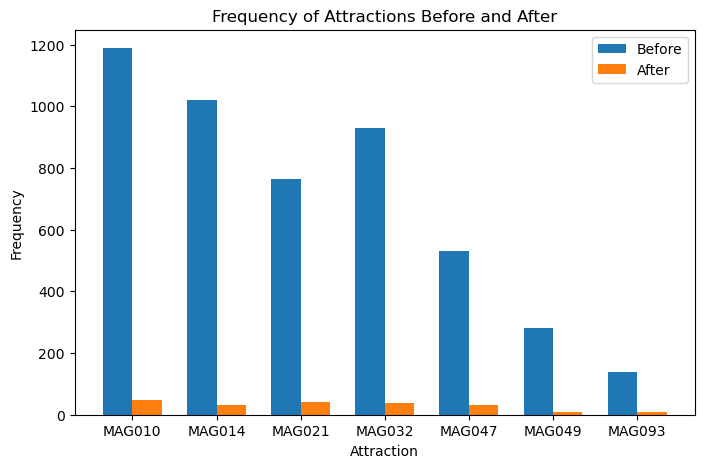

In [7]:
#HISTOGRAM OF REVIEW FREQUENCIES BEFORE AND AFTER COVID
# Create an array of indices for each attraction
indices = np.arange(len(P_attractions))

# Bar width
bar_width = 0.35

# Create subplots
fig, ax = plt.subplots(figsize=(8, 5))

# Plot "Before" bars
before_bars = ax.bar(indices - bar_width / 2, revFreq_before, bar_width, label='Before')

# Plot "After" bars
after_bars = ax.bar(indices + bar_width / 2, revFreq_after, bar_width, label='After')

# Set labels and title
ax.set_xlabel('Attraction')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Attractions Before and After')
ax.set_xticks(indices)
ax.set_xticklabels(P_attractions)
ax.legend()

# Show the plot
#plt.show()

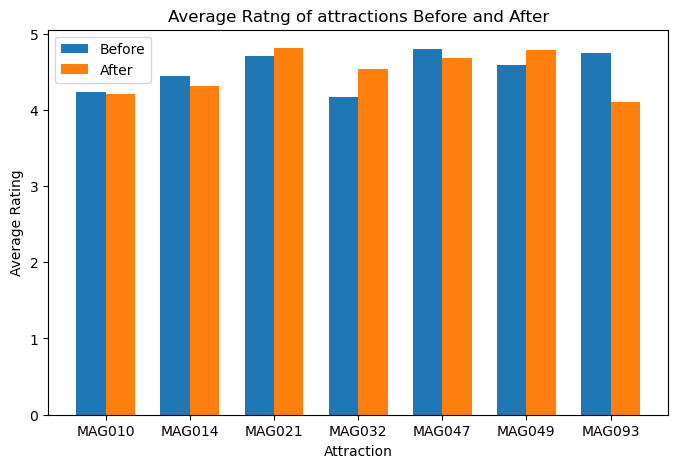

In [8]:
# Create an array of indices for each attraction
indices = np.arange(len(P_attractions))

# Bar width
bar_width = 0.35

# Create subplots
fig, ax = plt.subplots(figsize=(8, 5))

# Plot "Before" bars
before_bars = ax.bar(indices - bar_width / 2, avgRating_before, bar_width, label='Before')

# Plot "After" bars
after_bars = ax.bar(indices + bar_width / 2, avgRating_after, bar_width, label='After')

# Set labels and title
ax.set_xlabel('Attraction')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratng of attractions Before and After')
ax.set_xticks(indices)
ax.set_xticklabels(P_attractions)
ax.legend()

# Show the plot
plt.show()

In [9]:

#TO EXTRACT REVIEW FREQUENCIES BY COUNTRY OF ORIGIN (BEFORE)

country_before = pt_before['Country'].str.lower().str.strip()

# Remove rows with 'unknownl' in the 'Country' column
C_before = country_before[country_before != 'unknownl']

total_rows = len(pt_before)

# To print the top 20 rows by count size
Rv_before = C_before.value_counts().head(10)

Rv_before = (Rv_before / total_rows) * 100

Rv_before


united states     24.948538
united kingdom    21.407987
canada             7.245780
australia          3.972828
portugal           3.334706
ireland            2.223137
netherlands        1.626184
spain              1.317415
israel             1.193907
india              1.090984
Name: Country, dtype: float64

In [10]:
#TO EXTRACT REVIEW FREQUENCIES BY COUNTRY OF ORIGIN (BEFORE)

country_after = pt_after['Country'].str.lower().str.strip()

total_rows = len(pt_after)

# Remove rows with 'unknownl' in the 'Country' column
C_after = country_after[country_after != 'unknownl']

# To print the top 20 rows by count size
Rv_after = C_after.value_counts().head(10)
                                       
Rv_after = (Rv_after / total_rows) * 100 # As a percentage

Rv_after

united kingdom    23.923445
portugal          11.961722
united states     10.526316
france             4.306220
belgium            3.349282
netherlands        2.870813
spain              2.870813
italy              2.392344
germany            1.913876
canada             1.435407
Name: Country, dtype: float64

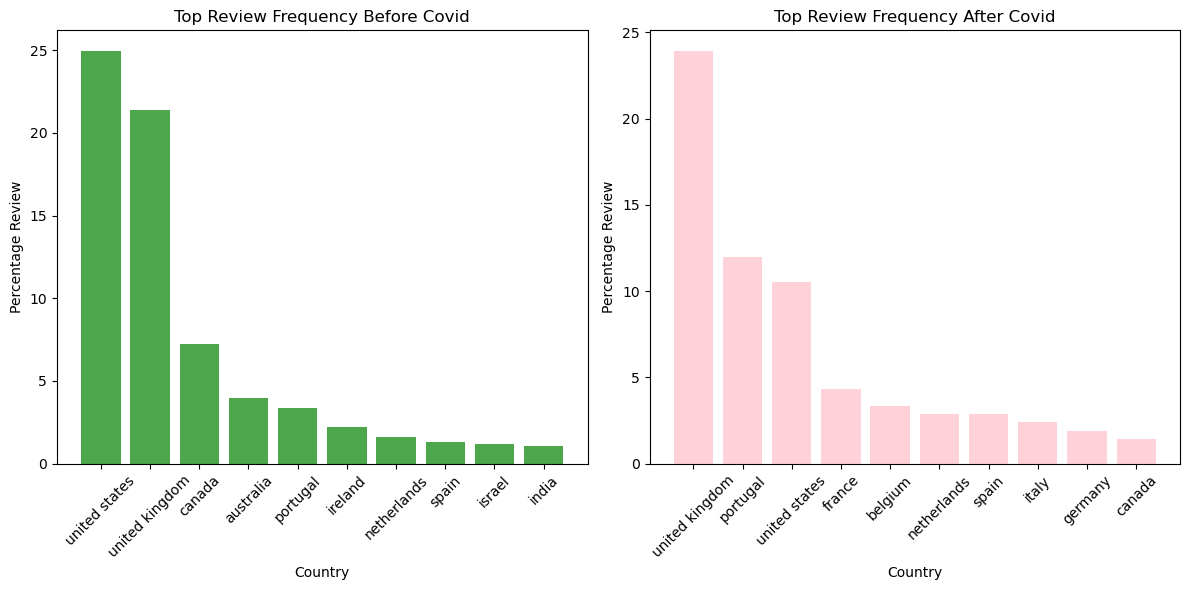

In [11]:
# Histogry of Review frequency by UserCountry
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting first histogram
axs[0].bar(Rv_before.index, Rv_before, color='green', alpha=0.7)
axs[0].set_title('Top Review Frequency Before Covid')
axs[0].set_xlabel('Country')
axs[0].set_ylabel('Percentage Review')
axs[0].tick_params(axis='x', rotation=45, )

# Plotting second histogram
axs[1].bar(Rv_after.index, Rv_after, color='pink', alpha=0.7)
axs[1].set_title('Top Review Frequency After Covid')
axs[1].set_xlabel('Country')
axs[1].set_ylabel('Percentage Review')
axs[1].tick_params(axis='x', rotation=45, )

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [12]:
#To Understand The Distribution Of trip types for the top three Countries visiting portugal
# BEFORE COVID
pt_before1 = pt_before.copy()  # Make a copy to avoid modifying the original DataFrame

# Apply lowercase and strip to the 'Country' column
pt_before1['Country'] = pt_before1['Country'].str.lower().str.strip()

# Select only rows for specified countries
top_3 = ['united states', 'united kingdom', 'canada']
pt_top = pt_before1[pt_before1['Country'].isin(top_3)]

# Select only desired columns
pt_top = pt_top[['Country', 'tripType']]


# Assuming pt_top is the DataFrame containing your data
trip_type = ['Friends', 'Couples', 'Family', 'Business', 'Solo', 'unknownT']

# Create an empty dictionary to store lists for each country
trip_type_counts = {}

# Iterate over unique countries in pt_top
for country in pt_top['Country'].unique():
    # Filter data for the current country
    country_data = pt_top[pt_top['Country'] == country]
    
    # Initialize a list to store counts for the current country
    counts_list = []
    
    # Iterate over trip_type and get the count for each category
    for trip_category in trip_type:
        count = country_data[country_data['tripType'] == trip_category].shape[0]
        counts_list.append(count)
    
    # Store the list of counts for the current country in the dictionary
    trip_type_counts[country] = counts_list

# Print the dictionary containing lists of counts for each country
print(trip_type_counts)


{'canada': [36, 140, 36, 2, 18, 120], 'united states': [136, 441, 123, 3, 71, 438], 'united kingdom': [117, 492, 97, 5, 48, 281]}


In [13]:
#AFTER COVID
pt_after1 = pt_after.copy()  # Make a copy to avoid modifying the original DataFrame

# Apply lowercase and strip to the 'Country' column
pt_after1['Country'] = pt_after1['Country'].str.lower().str.strip()

# Select only rows for specified countries
top_3 = ['united states', 'united kingdom', 'canada']
pt_top1 = pt_after1[pt_after1['Country'].isin(top_3)]

# Select only desired columns
pt_top1 = pt_top1[['Country', 'tripType']]


# Assuming pt_top is the DataFrame containing your data
trip_type = ['Friends', 'Couples', 'Family', 'Business', 'Solo', 'unknownT']

# Create an empty dictionary to store lists for each country
trip_type_counts1 = {}

# Iterate over unique countries in pt_top
for country in pt_top1['Country'].unique():
    # Filter data for the current country
    country_data1 = pt_top1[pt_top1['Country'] == country]
    
    # Initialize a list to store counts for the current country
    counts_list1 = []
    
    # Iterate over trip_type and get the count for each category
    for trip_category in trip_type:
        count1 = country_data1[country_data1['tripType'] == trip_category].shape[0]
        counts_list1.append(count1)
    
    # Store the list of counts for the current country in the dictionary
    trip_type_counts1[country] = counts_list1

# Print the dictionary containing lists of counts for each country
print(trip_type_counts1)


{'united kingdom': [6, 11, 3, 0, 8, 22], 'united states': [1, 5, 0, 0, 2, 14], 'canada': [0, 0, 0, 0, 1, 2]}


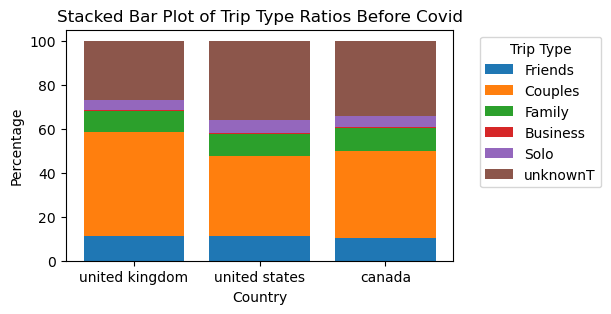

In [14]:
# Extract trip types
trip_types = ['Friends', 'Couples', 'Family', 'Business', 'Solo', 'unknownT']
Top_3 =['united kingdom', 'united states', 'canada']
# Normalize counts to percentages
trip_type_ratios = {country: np.array(counts) / np.sum(counts) * 100 for country, counts in trip_type_counts.items()}

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the stacked bars
bottom = np.zeros(len(Top_3))
for i, trip_type in enumerate(trip_types):
    values = [trip_type_ratios[country][i] for country in Top_3]
    ax.bar(Top_3, values, label=trip_type, bottom=bottom)
    bottom += np.array(values)

# Customize the plot
ax.set_xlabel('Country')
ax.set_ylabel('Percentage')
ax.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Stacked Bar Plot of Trip Type Ratios Before Covid')

# Show the plot
plt.show()

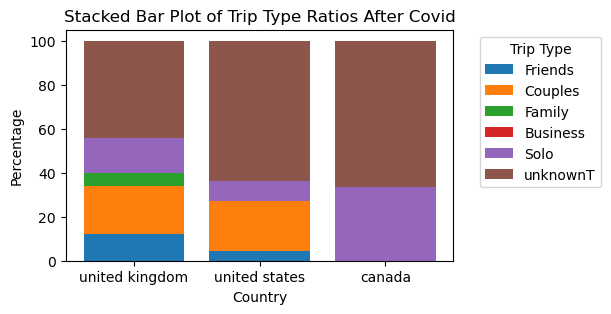

In [15]:
# Normalize counts to percentages
trip_type_ratios1 = {country: np.array(counts) / np.sum(counts) * 100 for country, counts in trip_type_counts1.items()}

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the stacked bars
bottom = np.zeros(len(Top_3))
for i, trip_type in enumerate(trip_types):
    values = [trip_type_ratios1[country][i] for country in Top_3]
    ax.bar(Top_3, values, label=trip_type, bottom=bottom)
    bottom += np.array(values)

# Customize the plot
ax.set_xlabel('Country')
ax.set_ylabel('Percentage')
ax.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Stacked Bar Plot of Trip Type Ratios After Covid')

# Show the plot
plt.show()

In [16]:
#To study Spain and Italy (Portugal's competitors), we include the a ISO column to our clean dataframe
# This would enable us easily identify and group reviews by country the attraction is located

LocalID_ISO = pd.read_excel('LocalID_ISO.xlsx') #to read the excel file containing attractions their country ISO 

# Merge the dataframes
df_merged = pd.merge(df_no_outliers, LocalID_ISO, left_on='localID', right_on='ID', how='left')

# Drop the redundant 'ID' column
df_merged = df_merged.drop(columns='ID')

# Rename the 'ISO' column to 'ISO' in the merged dataframe
df_merged= df_merged.rename(columns={'ISO': 'localISO'})

#To extract only data that falls in the time frame we are considering

# Define the start and end dates
start_date = '2018-09-01'
end_date = '2021-08-01'

# Filter rows based on the date range
df_ISO = df_merged[(df_merged['reviewVisited'] >= start_date) & (df_merged['reviewVisited'] <= end_date)]

df_ISO


,localID,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,Country,localISO
0,MAG001,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,United States,ES
1,MAG001,4.5,1,1186,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,Ireland,ES
2,MAG001,4.5,1,1186,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,Spain,ES
3,MAG001,4.5,1,1186,163828,James U@696jamesu,unknownL,7,unknownT,2021-08-16,2021-07-01,5,unknownL,ES
4,MAG001,4.5,1,1186,163828,Kamal K Sirra@Sirra63,"Madrid, Spain",516,Family,2021-08-15,2021-07-01,4,Spain,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84276,MAG100,4.5,11,677,5179,David M@DTM56,"Cambridge, UK",2055,Couples,2019-03-04,2019-02-01,5,United kingdom,IT
84277,MAG100,4.5,11,677,5179,robert_bos53@robert_bos53,"Geneva, Switzerland",1802,Friends,2019-02-25,2019-02-01,5,Switzerland,IT
84278,MAG100,4.5,11,677,5179,Mmarymomm@Mmarymomm,"Pleasanton, CA",1738,Couples,2019-02-14,2018-12-01,5,United States,IT
84279,MAG100,4.5,11,677,5179,KateJourney@KateJourney,"Exeter, Canada",185,unknownT,2019-02-12,2018-11-01,4,Canada,IT


In [17]:
#To obtain the review frequency for spanish attractions before and after covid
#BEFORE
# Define the start and end dates
start_date_condition = '2018-09-01'
end_date_condition = '2020-02-01'

# Filter rows based on the conditions
df_filtered_rows = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'ES')]
# Count the number of rows
ES_before = len(df_filtered_rows)

#AFTER

# Define the start and end dates
start_date_condition = '2020-03-01'
end_date_condition = '2021-08-01'

# Filter rows based on the conditions
df_filtered_rows1 = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'ES')]
# Count the number of rows
ES_after = len(df_filtered_rows1)



#To obtain the review frequency for Italian attractions before and after covid
#BEFORE
# Define the start and end dates
start_date_condition = '2018-09-01'
end_date_condition = '2020-02-01'

# Filter rows based on the conditions
df_flt_rows = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'IT')]
# Count the number of rows
IT_before = len(df_flt_rows)

#AFTER

# Define the start and end dates
start_date_condition = '2020-03-01'
end_date_condition = '2021-08-01'

# Filter rows based on the conditions
df_flt_rows1 = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'IT')]
# Count the number of rows
IT_after = len(df_flt_rows1)




#To obtain the review frequency for Italian attractions before and after covid
#BEFORE
# Define the start and end dates
start_date_condition = '2018-09-01'
end_date_condition = '2020-02-01'

# Filter rows based on the conditions
df_flt_rows = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'IT')]
# Count the number of rows
IT_before = len(df_flt_rows)

#AFTER

# Define the start and end dates
start_date_condition = '2020-03-01'
end_date_condition = '2021-08-01'

# Filter rows based on the conditions
df_flt_rows1 = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'IT')]
# Count the number of rows
IT_after = len(df_flt_rows1)



#To obtain the review frequency for Portuguese attractions before and after covid
#BEFORE
# Define the start and end dates
start_date_condition = '2018-09-01'
end_date_condition = '2020-02-01'

# Filter rows based on the conditions
df_flt_row = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'PT')]
# Count the number of rows
PT_before = len(df_flt_row)

#AFTER

# Define the start and end dates
start_date_condition = '2020-03-01'
end_date_condition = '2021-08-01'

# Filter rows based on the conditions
df_flt_rows2 = df_ISO[(df_ISO['reviewVisited'] >= start_date_condition) &
                          (df_ISO['reviewVisited'] <= end_date_condition) &
                          (df_ISO['localISO'] == 'PT')]
# Count the number of rows
PT_after = len(df_flt_rows2)

print(IT_before)
IT_after


5224


407

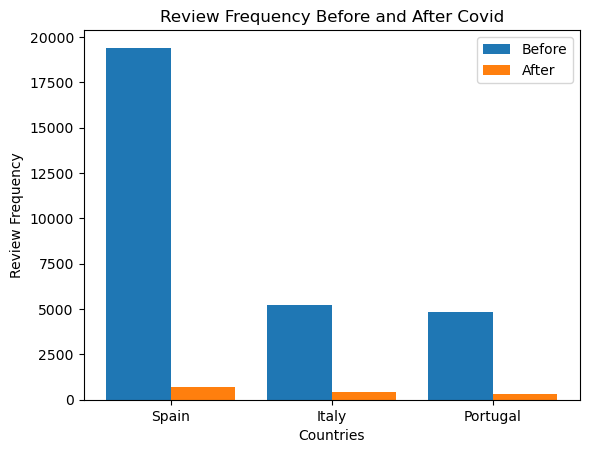

In [18]:
# Histogram Of Review Frequency
# Define the countries and corresponding variables
countries = ['Spain', 'Italy', 'Portugal']
before_values = [ES_before, IT_before, PT_before]
after_values = [ES_after, IT_after, PT_after]

# Set up positions for bars
bar_positions = np.arange(len(countries))

# Plotting the bars
plt.bar(bar_positions - 0.2, before_values, width=0.4, label='Before')
plt.bar(bar_positions + 0.2, after_values, width=0.4, label='After')

# Set labels and title
plt.xlabel('Countries')
plt.ylabel('Review Frequency')
plt.title('Review Frequency Before and After Covid')
plt.xticks(bar_positions, countries)

# Show legend
plt.legend()

# Show the plot
plt.show()

In [19]:
# PHASE MODELING

#To understand Visitors Frequent Itemset association for portuguese attractions
# To obtain usernames that visited PT 
pt_usernames = df_merged.loc[df_merged['localISO'] == 'PT', 'userName'].tolist()

# To include other countries those users visited in the past
pt_rows = df_merged[df_merged['userName'].isin(pt_usernames)]

#TO drop columns not needed in our market basket analysis
pt_vst = pt_rows[['localISO', 'userName', 'reviewVisited', 'localID']]


# Create a new column 'tripNumber' with randomly generated values for each unique pair of userName and reviewVisited
pt_vst['tripNumber'] = pt_vst.groupby(['userName', 'reviewVisited']).ngroup()

#To drop these columns"userName", "reviewVisited", "localISO"
pt_vst1 = pt_vst.drop(["userName", "reviewVisited", "localISO"], axis=1)

#TO create a pivot table
pt_pv = pd.pivot_table(pt_vst1, columns=pt_vst1['localID'], index=pt_vst1['tripNumber'], aggfunc=lambda x: 1, fill_value=0)
pt_pv

C:\Users\nwach\AppData\Local\Temp\ipykernel_17032\1405619993.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt_vst['tripNumber'] = pt_vst.groupby(['userName', 'reviewVisited']).ngroup()


localID,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,MAG010,...,MAG090,MAG091,MAG092,MAG093,MAG094,MAG095,MAG096,MAG097,MAG098,MAG100
tripNumber,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4724,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#APPLY THE APRIORI ALGORITHM
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(pt_pv, min_support=0.02, use_colnames=True)
frequent_itemsets

C:\Users\nwach\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.031091,(MAG001)
1,0.273266,(MAG010)
2,0.231810,(MAG014)
3,0.176184,(MAG021)
4,0.211717,(MAG032)
5,0.123308,(MAG047)
6,0.063663,(MAG049)
7,0.028553,(MAG093)
8,0.082276,"(MAG010, MAG014)"
9,0.032783,"(MAG010, MAG032)"


In [21]:
# Generate the association rules - by support
rulesSupport = association_rules(frequent_itemsets, metric="support", min_threshold=0.02)
rulesSupport.sort_values(by='support', ascending=False, inplace=True)
rulesSupport

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(MAG010),(MAG014),0.273266,0.231810,0.082276,0.301084,1.298835,0.018930,1.099115,0.316593
1,(MAG014),(MAG010),0.231810,0.273266,0.082276,0.354927,1.298835,0.018930,1.126592,0.299509
8,(MAG047),(MAG032),0.123308,0.211717,0.050973,0.413379,1.952504,0.024866,1.343768,0.556452
9,(MAG032),(MAG047),0.211717,0.123308,0.050973,0.240759,1.952504,0.024866,1.154696,0.618861
4,(MAG014),(MAG032),0.231810,0.211717,0.033418,0.144161,0.680910,-0.015660,0.921064,-0.378895
5,(MAG032),(MAG014),0.211717,0.231810,0.033418,0.157842,0.680910,-0.015660,0.912168,-0.372838
2,(MAG010),(MAG032),0.273266,0.211717,0.032783,0.119969,0.566647,-0.025072,0.895744,-0.512750
3,(MAG032),(MAG010),0.211717,0.273266,0.032783,0.154845,0.566647,-0.025072,0.859883,-0.492429
6,(MAG021),(MAG049),0.176184,0.063663,0.032149,0.182473,2.866220,0.020932,1.145328,0.790357
7,(MAG049),(MAG021),0.063663,0.176184,0.032149,0.504983,2.866220,0.020932,1.664218,0.695379


In [22]:
#RFM
pt_df = df_merged[df_merged['localISO'] == 'PT']
columns_to_keep = ["userName", "reviewRating", "Country", "reviewVisited"]
pt_df = pt_df[columns_to_keep]
pt_df

,userName,reviewRating,Country,reviewVisited
27527,Barbs25@Barbs25,3,United kingdom,2021-07-01
27528,WWH47@WWH47,5,United States,2021-07-01
27529,Runawayblond@runawayblond,4,United States,2021-06-01
27530,Darren H@DarrenHumphrey,5,United States,2021-06-01
27531,Kevin S@kevins684,4,United kingdom,2021-07-01
...,...,...,...,...
83305,JAFL@Joao-Jafl,5,Portugal,2019-01-01
83306,Loveitta@Loveitta,5,United kingdom,2019-01-01
83307,Kaytd60@Kaytd60,5,Australia,2018-09-01
83308,BlueSkyTravell@BlueSkyTravell,5,Germany,2019-01-01


In [23]:
# 
pt_df['reviewVisited'] = pd.to_datetime(pt_df['reviewVisited'])

# Set the dateMax to a Timestamp object
dateMax = pd.to_datetime('2021-08-21')
X = pt_df.groupby(['userName']).agg(Recency=('reviewVisited', lambda date: (dateMax - date.max()).days),
                                   Frequency=('reviewVisited', lambda i: len(i.unique())),
                                   Monetary=('reviewRating', 'mean')).fillna(0)
X

,Recency,Frequency,Monetary
userName,,,
007JNR@007JNR,873,1,4.000000
0Garza@0Garza,567,1,3.666667
101eggie@101eggie,690,1,1.000000
1104@1104,843,1,5.000000
110Helen2014@110Helen2014,567,1,5.000000
...,...,...,...
Екатерина Г@_C5261QZ,1085,1,5.000000
Олександр П@X5628EZ_,567,1,4.000000
Симеон Б@FrequentFlier415125,812,1,5.000000


In [24]:
# Determinining RFM cutting points based on the quartiles (default for pandas "describe")
cols = ['Recency','Frequency','Monetary']
table = X[cols].describe()
table

,Recency,Frequency,Monetary
count,3948.000000,3948.000000,3948.000000
mean,769.524063,1.023556,4.420361
std,166.568789,0.153342,0.857301
min,20.000000,1.000000,1.000000
25%,690.000000,1.000000,4.000000
50%,782.000000,1.000000,5.000000
75%,873.000000,1.000000,5.000000
max,1297.000000,3.000000,5.000000


In [25]:
# Calculate RMF scores

# Function
def RFMScore(x, col):
    if x <= col.quantile(0.25):
        return '1'
    elif x <= col.quantile(0.5):
        return '2'
    elif x <= col.quantile(0.75):
        return '3'
    else:
        return '4'
    
def RFM2(x, col):
    if x <= 3:
        return '1'
    elif x < 4:
        return '2'
    elif x < 5:
        return '3'
    else:
        return '4'

# Process
X['RScore'] = X['Recency'].apply(RFMScore, col=X['Recency'])
X['FScore'] = X['Frequency'].apply(RFMScore, col=X['Frequency'])
X['MScore'] = X['Monetary'].apply(RFM2, col=X['Monetary'])
X.head(5)

,Recency,Frequency,Monetary,RScore,FScore,MScore
userName,,,,,,
007JNR@007JNR,873,1,4.000000,3,1,3
0Garza@0Garza,567,1,3.666667,1,1,2
101eggie@101eggie,690,1,1.000000,1,1,1
1104@1104,843,1,5.000000,3,1,4
110Helen2014@110Helen2014,567,1,5.000000,1,1,4


In [26]:
# Create a column with full RMF score and sort the results

# Transform to string
cols = ['RScore','FScore','MScore']
X[cols] = X[cols].astype(str)

# Concatenate
X['RFMScore'] = X['RScore'] + X['FScore'] + X['MScore']

# Sort
X = X.sort_values(by=['RFMScore'])
X.head(5)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
userName,,,,,,,
Farfalle@bertonkat,690,1,3.0,1,1,1,111
DCEowner@DCEowner,538,1,3.0,1,1,1,111
Jinjuko@Jinjuko,385,1,3.0,1,1,1,111
alisa8va@alisa8va,659,1,3.0,1,1,1,111
Sightseer448496@Sightseer448496,690,1,1.0,1,1,1,111


In [27]:
# Calculate statistics per RFM segment
RFMStats = X.reset_index().groupby(['RFMScore']).agg(NrUsers=('userName', lambda i: len(i.unique())),
                                                     avgRecency=('Recency', 'mean'),
                                                     avgFrequency=('Frequency', 'mean'),
                                                     avgMonetary=('Monetary', 'mean')).fillna(0)
RFMStats

,NrUsers,avgRecency,avgFrequency,avgMonetary
RFMScore,,,,
111,130,576.046154,1.000000,2.376923
112,14,619.928571,1.000000,3.535714
113,310,588.770968,1.000000,4.143126
114,681,585.809104,1.000000,5.000000
142,3,618.666667,2.000000,3.555556
143,25,556.880000,2.000000,4.389333
144,16,539.250000,2.000000,5.000000
211,129,747.395349,1.000000,2.492248
212,20,743.250000,1.000000,3.537500


In [28]:
# Check who are the customers from a specific segment (e.g."144")
X[X['RFMScore']=='144']


,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
userName,,,,,,,
Michael M@heartlandmo,690,2,5.0,1,4,4,144
shereenbourne@shereenbourne,567,2,5.0,1,4,4,144
Finds_posts@Lowell-Fin,446,2,5.0,1,4,4,144
johnpV4713TS@johnpV4713TS,659,2,5.0,1,4,4,144
cartagia@cartagia,659,2,5.0,1,4,4,144
Yorkylass82@Yorkylass82,690,2,5.0,1,4,4,144
Valéria@valtestaa,293,2,5.0,1,4,4,144
Clark845@Clark845,690,2,5.0,1,4,4,144
Alexandre C@Alexclondon95,81,2,5.0,1,4,4,144


C:\Users\nwach\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


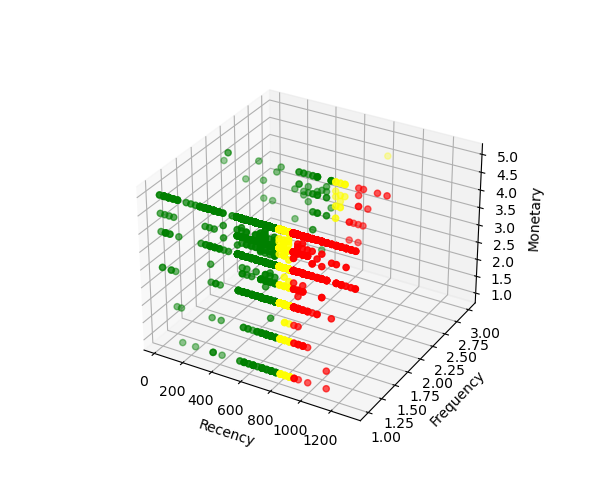

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipympl
from mpl_toolkits.mplot3d import Axes3D
import squarify
#import category_encoders as ce
# Interactive 3D scatter plot of each customer's RFM values
%matplotlib widget

# Draw
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection = '3d')

# Decoration
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# Define color according to Recency (1 and 2:Green, 3:Yellow, 4:Red)
color = ['green' if x[0]<'3' else ('yellow' if x[0]=='3' else 'red') for x in X['RFMScore']]

# Plot
ax.scatter(X['Recency'], X['Frequency'], X['Monetary'], c=color)
plt.show()

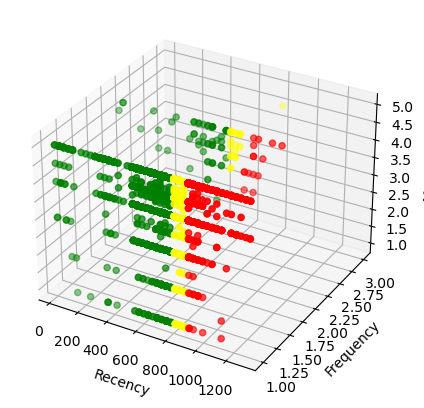

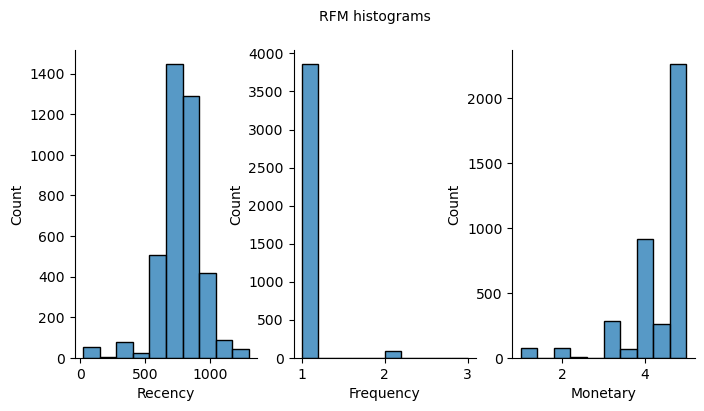

In [30]:
# Histogram of RFM
%matplotlib inline
cols = ['Recency','Frequency','Monetary']

# Draw
fig, ax = plt.subplots(1, 3, figsize=(8,4))
for var, subplot in zip(X[cols], ax.flatten()):
    g = sns.histplot(data=X,
                bins=10,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=10)
fig.suptitle("RFM histograms", fontsize=10);

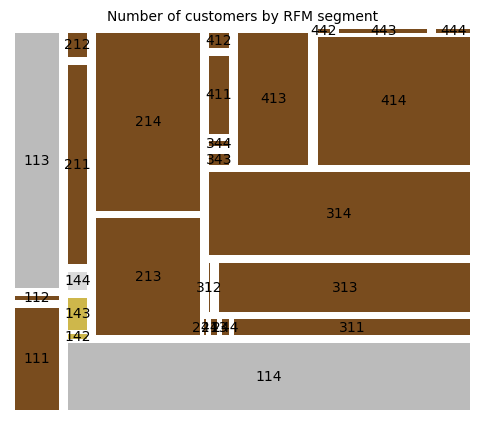

In [31]:
# Treemap with number of customers by segment
import squarify
# Define colors for levels
def assignColor(rfm):
    if (rfm=='144'):
        hex='#D7D7D7'   # Platinium
    elif (rfm in ['142','143','133','134','124']):
        hex='#C9B037'   # Gold
    elif (rfm in ['141','131','132','122','123','113','114']):
        hex='#B4B4B4'   # Silver
    else:
        hex='#6A3805'   # Bronze
    return hex

color = [assignColor(x) for x in RFMStats.index]

# Draw
fig, ax = plt.subplots(figsize=(6,5))

# Plot
squarify.plot(sizes=RFMStats['NrUsers'], 
              label=RFMStats.index,
              color = color,
              alpha=.9,
              pad=True)                    

# Decoration
plt.title("Number of customers by RFM segment",fontsize=10)
plt.axis('off')
plt.show()

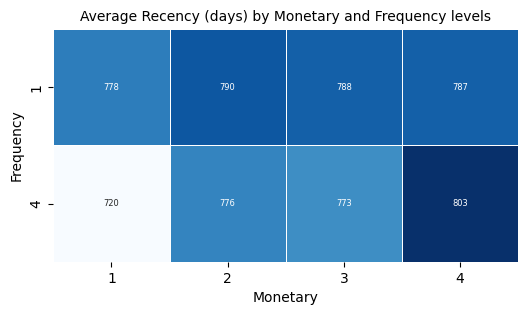

In [32]:
# RFM Heatmap
import seaborn as sns
# Prepare data
tempDF = RFMStats
tempDF['Frequency'] = tempDF.index.str[1]
tempDF['Monetary'] = tempDF.index.str[2]
pt = pd.pivot_table(tempDF, values='avgRecency', 
                     index=['Frequency'], 
                     columns='Monetary')

# Draw
fig , ax = plt.subplots(figsize=(6, 5))
heatmap = sns.heatmap(pt,
                      square = True,
                      linewidths = .5,
                      cmap = 'Blues',
                      cbar=False,
                      fmt='.0f',
                      annot = True,
                      annot_kws = {'size': 6})
                     
    

# Decoration
plt.title("Average Recency (days) by Monetary and Frequency levels", fontsize=10)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})